In [1]:
import numpy as np
import copy as cp 
import random
from tqdm import tqdm_notebook as tqdm

### Define the Environment

A server requires information from a sensor. The server would like the information to be fresh. However, there is a cost to querying information from the sensor. 
<ol>
    <li>The state at the server canbe either fresh or stale. The former indicates that the information at the server about the sensor is fresh and the latter indicates that it is stale.</li> 
    <li>At any time, the server may choose to query or remain silent. </li>
   </ol>
MDP given in the diagrma

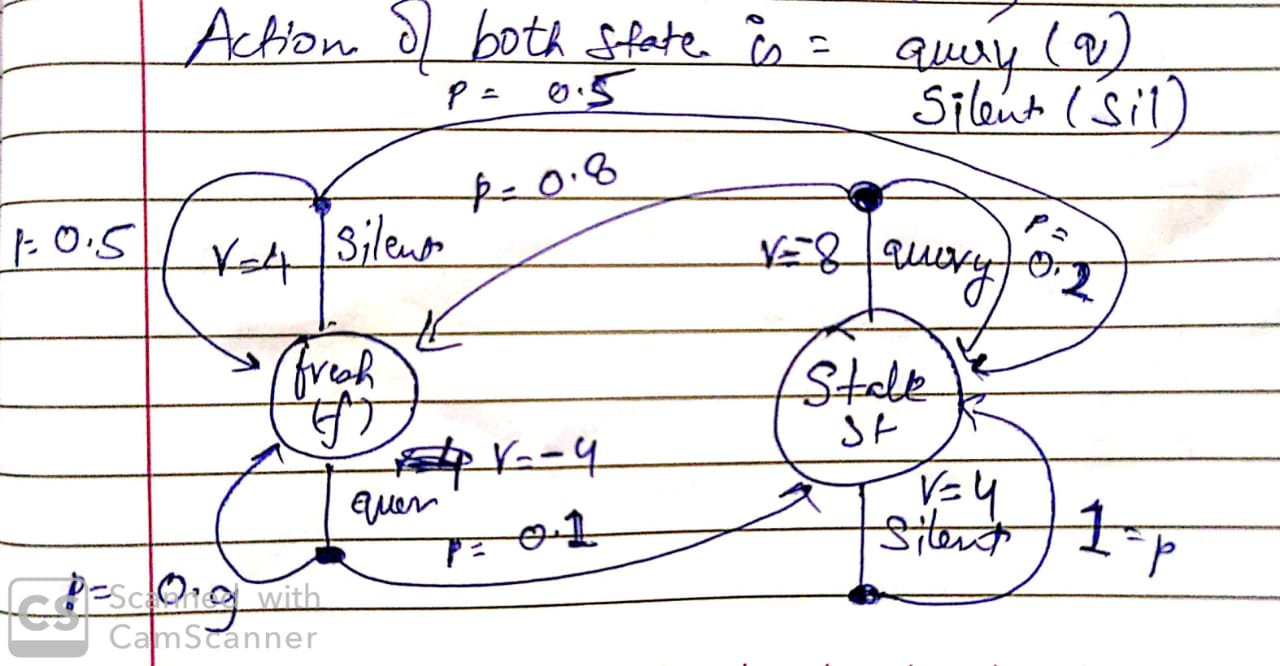

In [2]:
class ServerProb():
    def __init__(self):
        '''
        Initialize the Gridword
        self.state (list) : How many non-termimal state does this GridWordHave
        self.statePlus : Non terminal + terminal state
        self.posibleStateAction : Possible action for each state
        self.dynamic : Dynamics of this GridWorld
        '''
        self.state = np.arange(1,3)
        self.statePlus = np.arange(1,3)
        self.posibleStateAction = self.defPossibleStateAction()
        self.dynamic = self.defineDynamic() 
        
    def defPossibleStateAction(self):
        #defining Possible action for this ServerProb
        posibleStateAction = dict()
        for s in self.state:
            posibleStateAction[s] = [1,2]  #query,silent
        return posibleStateAction
    
    def defineDynamic(self):
        #defining the dynamics of the Environmvent
        dynamic = dict()
        dynamic[(1,1)] = [(1,-4,0.9),(2,-4,.1)]
        dynamic[(1,2)] = [(1,4,.5),(2,4,.5)]
        dynamic[(2,1)] = [(1,-8,0.8),(2,-8,.2)]
        dynamic[(2,2)] = [(2,4,1)]
        return dynamic

### Policy Iteration 

Below we have implemented below Algorithm:

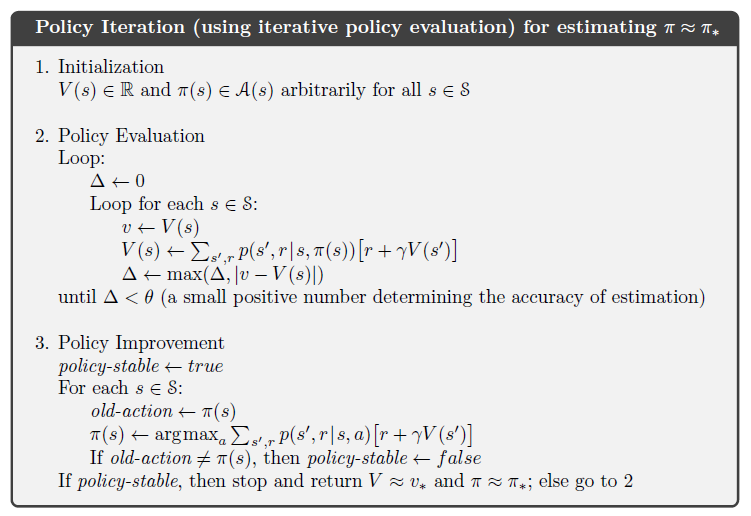

In [11]:
def policyEvaluation(policy,env,v,gamma = 0.5,threshold=0.1):
    '''
    This method will evaluate the policy given to it i.e Step 2 of above pesudocode
    '''
    hist = []
    while True:
        delta = 0
        for s in env.state:
            vtemp = 0
            for action,sprob in policy[s]:
                for sDash,reward,prob in env.dynamic[(s,action)]:
                    vtemp += sprob * prob * (reward + gamma * v[sDash-1])
            delta = max(delta,abs(vtemp-v[s-1]))
            v[s-1] = vtemp
        #print(v,delta)
        hist.append(cp.deepcopy(v))
        if (delta < threshold):
            break;
    return hist

In [12]:
def oneStepLookAhead(s,env,v,gamma = 0.5):
    '''
    This method is use to do a one step lookahead.
    It is used when when we when we were imporivng the policy Step 3
    '''
    actionReward = []
    for action in env.posibleStateAction[s]:
        act = 0
        for sDash,reward,prob in env.dynamic[(s,action)]:
            act += prob * (reward + gamma * v[sDash-1])
        actionReward.append(act)
    return actionReward

In [13]:
def policyImprove(policy,env,v):
    '''
    This is a method to improve the policy according the values that have been calculated perviously
    '''
    stablePolicy = True
    newPolicy = dict()
    for s in env.state:
        prob = [j for _,j in policy[s]]
        #getting all the best action according to old policy.
        bestActionProb = max(prob)
        oldBestAction = set([act for act,proba in policy[s] if proba == bestActionProb])
        #get the values from each of values function
        actionRewards = oneStepLookAhead(s,env,v)
        #placing 1 which has the hightest values
        maxReward = [1 if i == max(actionRewards) else 0 for i in actionRewards ]
        #finding the probability
        maxReward = maxReward/np.sum(maxReward)
        #getting the best action to compare 
        newbestAction = set(np.argwhere(maxReward > 0).flatten()+1)
        #making the new Policy
        newPolicy[s] = [(i+1,j) for i,j in enumerate(maxReward) ]
        if(oldBestAction != newbestAction):
            #print(s,oldBestAction,newbestAction)
            stablePolicy = False
    return (stablePolicy,newPolicy)

In [14]:
def initilizeRandomPolicy(env):
    '''
    Initialze a equi-probabel policy.
    '''
    policy = dict()
    action = [1,2]
    prob = [0.5]*2
    for s in env.state:
        policy[s] = list(zip(action,prob))
    return policy

In [15]:
def printPolicy(policy):
    print("state \t [query,\t       silent]")
    for key in policy:
        print(key ,"\t", policy[key])

In [16]:
env = ServerProb() 
v = np.zeros(len(env.statePlus))
policy = initilizeRandomPolicy(env)
history = dict()
policyDict = dict()
policyDict[0] = policy
i = 1
while True:
    hist = policyEvaluation(policy,env,v)
    history[i] = hist
    isStable,policy = policyImprove(policy,env,hist[-1])
    policyDict[i] = policy
    i+=1
    v = hist[-1]
    if isStable ==True:
        break;

In [17]:
history

{1: [array([ 0., -2.]),
  array([-0.3 , -2.66]),
  array([-0.504 , -2.8988]),
  array([-0.61122 , -2.991884]),
  array([7.91397178, 7.91382729])],
 2: [array([3.07679582, 2.48494644]),
  array([5.39043557, 5.24247322]),
  array([6.6582272 , 6.62123661]),
  array([7.31986595, 7.31061831]),
  array([7.65762106, 7.65530915]),
  array([7.82823255, 7.82765458]),
  array([7.91397178, 7.91382729])]}

In [18]:
policyDict

{0: {1: [(1, 0.5), (2, 0.5)], 2: [(1, 0.5), (2, 0.5)]},
 1: {1: [(1, 0.0), (2, 1.0)], 2: [(1, 0.0), (2, 1.0)]},
 2: {1: [(1, 0.0), (2, 1.0)], 2: [(1, 0.0), (2, 1.0)]}}